In [1]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import seaborn as sns

In [2]:
sys.path.insert(0, os.path.join(os.path.split(os.path.abspath(""))[0], "app"))
from preprocessing import DataPreprocess

In [3]:
# read prepared df with 60 min frequancy
df = pd.read_csv("df_171022_231222.csv")
df.columns

Index(['Timestamp', '309', '317', '319', '327', '481', 'Qdis', '381', '395',
       '406', '407', '408', '409', '381_c', '395_c'],
      dtype='object')

# The overall idea is to predict temperature before HE
## The key parameters to accomplish task are:
* Status of ctfs (enabled/disabled)
* Air temperature
* Month, dat, hour that have concrete correlation with T of air and ctfs operation

## Feature engineering required:
* retrive Month, day and hour values for each row
* use trigonometric transoformation to show explicit cyclic dependencies

In [4]:
# drop 381 and 395 (ctf1 and ctf2) numerical values
# drop all columns that are not going to be used
df_use = df.drop(labels=['309', '319', "381","395", '481', 'Qdis', '406', '407',
           '408', '409'], axis=1)

In [5]:
y = df_use["317"]
X = df_use.drop(["317"], axis=1)
X["Timestamp"] = pd.to_datetime(X["Timestamp"])

In [6]:
X_init = X.copy()

In [7]:
# DataPreprocess instance
dp = DataPreprocess()

In [8]:
# our data is cyclic type
# apply feature engineering to create new columns

X["Hour"] = dp.retrieve_datatime(X["Timestamp"], "hour")
X["Day"] = dp.retrieve_datatime(X["Timestamp"], "day")
X["Month"] = dp.retrieve_datatime(X["Timestamp"], "month")

# drop Timestamp col
X = X.drop("Timestamp", axis=1)

In [9]:
X

,327,381_c,395_c,Hour,Day,Month
0,5.754091,1,1,18,17,10
1,5.632039,1,1,19,17,10
2,5.305963,1,1,20,17,10
3,4.877073,1,1,21,17,10
4,4.478302,1,1,22,17,10
...,...,...,...,...,...,...
537,-21.457674,0,0,10,23,12
538,-20.816818,0,1,11,23,12
539,-20.190611,0,1,12,23,12
540,-20.048624,0,1,13,23,12


<AxesSubplot: >

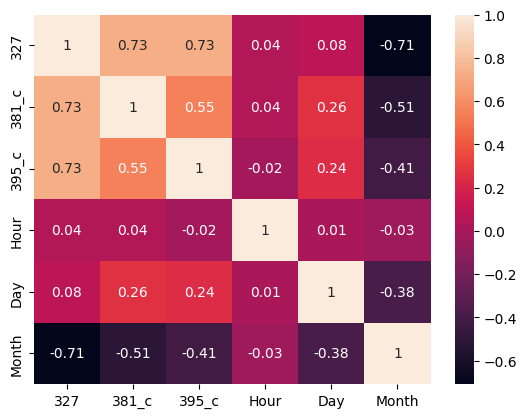

In [10]:
# just quick view on columns correlations without Datetime preprocessing
# the raw month column  provide the worst correletation (obvious)
sns.heatmap(X.corr().round(2), annot=True)

In [11]:
# convert m,d,h into dummies
# Hour were dropped as there are no positive correlations with core data
ohe = OneHotEncoder()
dum_col = X.loc[:, ["Month", "Day"]]
ohe_dt = ohe.fit_transform(dum_col).toarray()
ohe_labels = [*ohe.categories_]
# X_dum

In [12]:
# new df with datetime columns which are ohe
df_dt_ohe = pd.DataFrame(ohe_dt, columns=[*ohe_labels[0], *ohe_labels[1]])

In [13]:
# merge with Tair amd ctf cols
df_mer_ohe = pd.concat([X.loc[:, ["327", "381_c", "395_c"]], df_dt_ohe], axis=1)
df_mer_ohe.columns = df_mer_ohe.columns.astype(str)

In [14]:
# just quick view on columns correlations with Datetime one hot encoded
# fig, ax = plt.subplots(figsize=(50,50))
# sns.heatmap(df_mer_ohe.corr().round(2), annot=True, ax=ax)
# plt.savefig("hm.png")

In [15]:
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor

ts_cv = TimeSeriesSplit(
    n_splits=4,
    gap=200,
    max_train_size=160,
    test_size=70,
)

In [16]:
def evaluate(model, X, y, cv):
#     print(X)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [17]:
ct1 = ColumnTransformer(
        [
            ("norm", Normalizer(), ["327"]),
            ("onehot", OneHotEncoder(sparse_output=True),
                 ["Hour", "Day", "Month"])
        ],  remainder="passthrough")
X_tr = ct1.fit_transform(X).toarray()
X_tr

array([[ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 1.,  0.,  0., ...,  0.,  1.,  1.],
       ...,
       [-1.,  0.,  0., ...,  1.,  0.,  1.],
       [-1.,  0.,  0., ...,  1.,  0.,  1.],
       [-1.,  0.,  0., ...,  1.,  0.,  1.]])

In [18]:
splits_1 = list(ts_cv.split(X_tr, y))
# splits_1

In [19]:
# GradientBoostingRegressor chosen as nonlinear model to train
gbr = GradientBoostingRegressor()

In [20]:
# 2 evaluations: one where hour, day and month are used as ohe data
# other uses only month and day as oge data
evaluate(gbr, X_tr, y, ts_cv), evaluate(gbr, df_mer_ohe, y, ts_cv)

Mean Absolute Error:     2.618 +/- 1.719
Root Mean Squared Error: 2.958 +/- 1.964
Mean Absolute Error:     2.587 +/- 1.773
Root Mean Squared Error: 2.988 +/- 1.844


(None, None)

# all data bellow must be rewritten into more consistent style

In [21]:
for tr, te in splits_1:
    gbr.fit(X_tr[tr], y.iloc[tr])

In [22]:
gbr_score_1 = []
for tr, te in splits_1:
    gbr_score_1.append(gbr.score(X_tr[tr], y.iloc[tr]))

In [23]:
gbr_te_1 = []
for tr, te in splits_1:
    gbr_te_1.append(gbr.predict(X_tr[te]))

In [24]:
gbr_tr_1 = []
for tr, te in splits_1:
    gbr_tr_1.append(gbr.predict(X_tr[tr]))

In [25]:
import matplotlib.pyplot as plt

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70')])

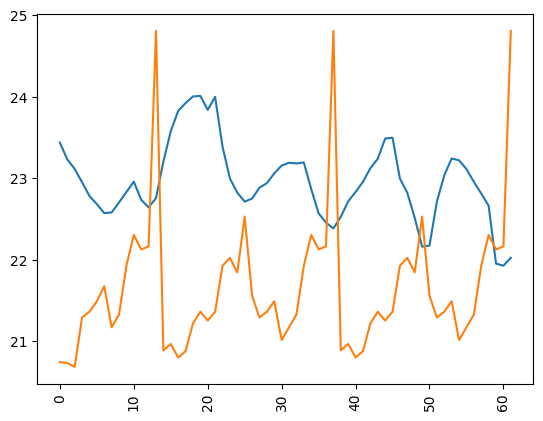

In [26]:
# prediction on train data and origin label
# 0st train set
ind = 0
plt.plot(X.index[splits_1[ind][0]], y[splits_1[ind][0]])
plt.plot(X.index[splits_1[ind][0]], gbr_tr_1[ind])
plt.xticks(rotation=90)

(array([250., 260., 270., 280., 290., 300., 310., 320., 330., 340.]),
 [Text(250.0, 0, '250'),
  Text(260.0, 0, '260'),
  Text(270.0, 0, '270'),
  Text(280.0, 0, '280'),
  Text(290.0, 0, '290'),
  Text(300.0, 0, '300'),
  Text(310.0, 0, '310'),
  Text(320.0, 0, '320'),
  Text(330.0, 0, '330'),
  Text(340.0, 0, '340')])

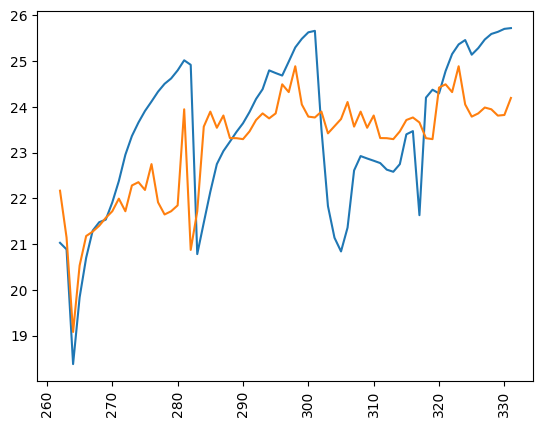

In [27]:
# prediction on train data and origin label
# 0st test set
ind = 0
plt.plot(X.index[splits_1[ind][1]], y[splits_1[ind][1]])
plt.plot(X.index[splits_1[ind][1]], gbr_te_1[ind])
plt.xticks(rotation=90)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120'),
  Text(140.0, 0, '140')])

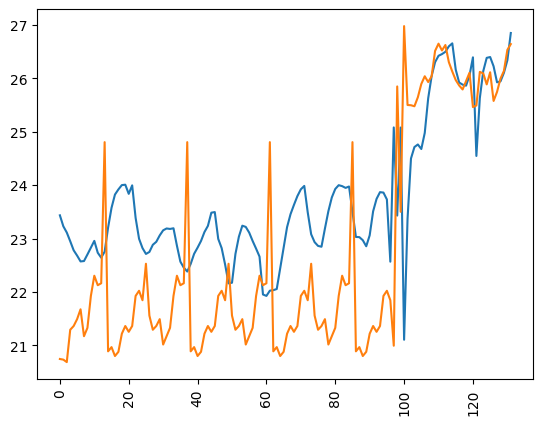

In [28]:
# prediction on train data and origin label
# 1st train set
ind = 1
plt.plot(X.index[splits_1[ind][0]], y[splits_1[ind][0]])
plt.plot(X.index[splits_1[ind][0]], gbr_tr_1[ind])
plt.xticks(rotation=90)

(array([320., 330., 340., 350., 360., 370., 380., 390., 400., 410.]),
 [Text(320.0, 0, '320'),
  Text(330.0, 0, '330'),
  Text(340.0, 0, '340'),
  Text(350.0, 0, '350'),
  Text(360.0, 0, '360'),
  Text(370.0, 0, '370'),
  Text(380.0, 0, '380'),
  Text(390.0, 0, '390'),
  Text(400.0, 0, '400'),
  Text(410.0, 0, '410')])

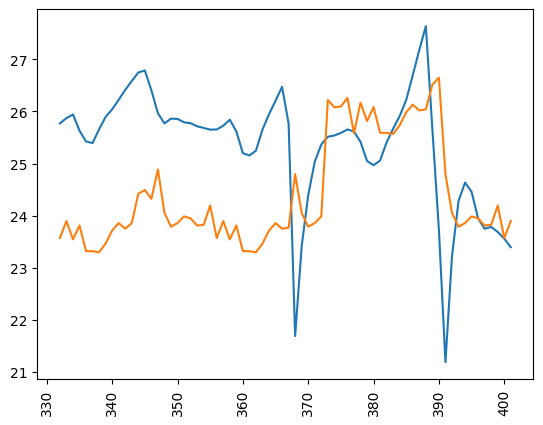

In [29]:
# prediction on train data and origin label
# 1st test set
ind = 1
plt.plot(X.index[splits_1[ind][1]], y[splits_1[ind][1]])
plt.plot(X.index[splits_1[ind][1]], gbr_te_1[ind])
plt.xticks(rotation=90)

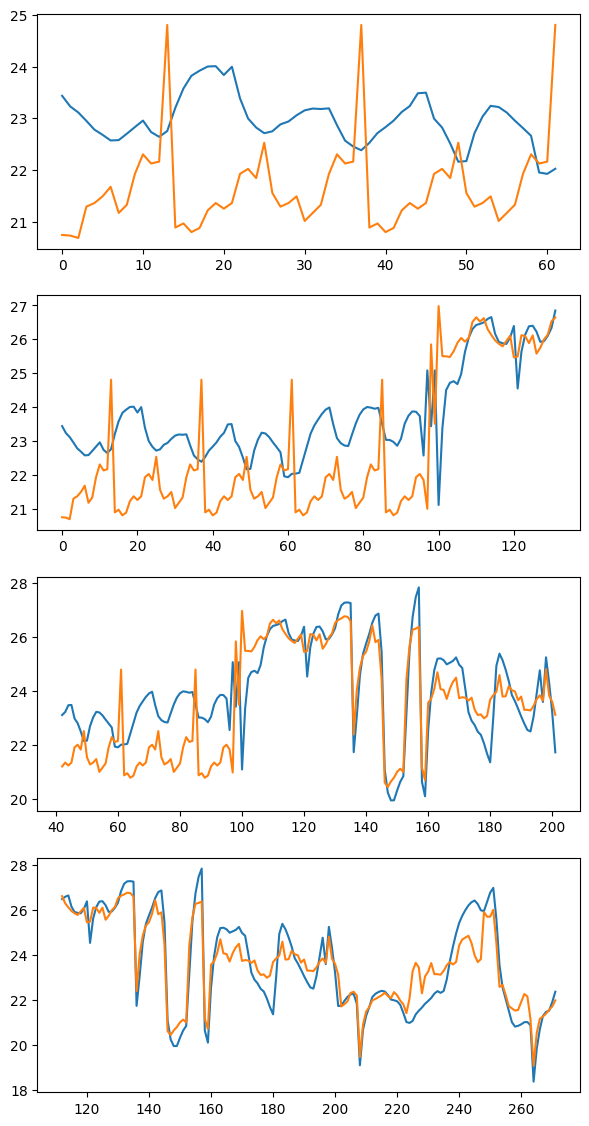

In [30]:
# lets plot all data together
#train and origin
fig, axs = plt.subplots(4,1, figsize=(7,14))
axs[0].plot(X.index[splits_1[0][0]], y[splits_1[0][0]])
axs[0].plot(X.index[splits_1[0][0]], gbr_tr_1[0])

axs[1].plot(X.index[splits_1[1][0]], y[splits_1[1][0]])
axs[1].plot(X.index[splits_1[1][0]], gbr_tr_1[1])

axs[2].plot(X.index[splits_1[2][0]], y[splits_1[2][0]])
axs[2].plot(X.index[splits_1[2][0]], gbr_tr_1[2])

axs[3].plot(X.index[splits_1[3][0]], y[splits_1[3][0]])
axs[3].plot(X.index[splits_1[3][0]], gbr_tr_1[3])

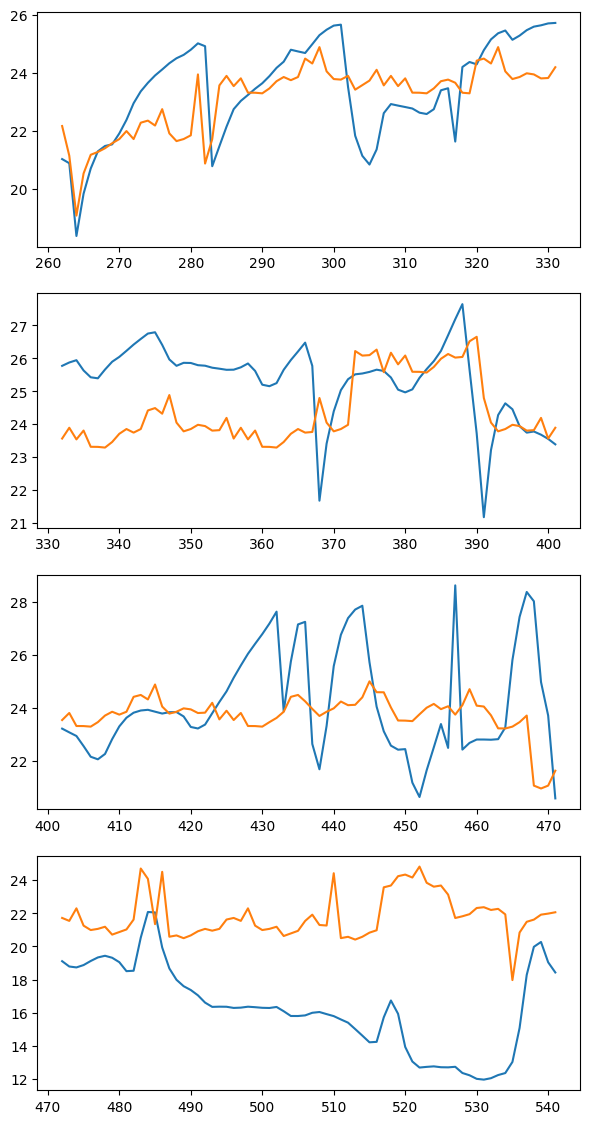

In [31]:
# fit and origin label
#train and origin
fig, axs = plt.subplots(4,1, figsize=(7,14))
axs[0].plot(X.index[splits_1[0][1]], y[splits_1[0][1]])
axs[0].plot(X.index[splits_1[0][1]], gbr_te_1[0])

axs[1].plot(X.index[splits_1[1][1]], y[splits_1[1][1]])
axs[1].plot(X.index[splits_1[1][1]], gbr_te_1[1])

axs[2].plot(X.index[splits_1[2][1]], y[splits_1[2][1]])
axs[2].plot(X.index[splits_1[2][1]], gbr_te_1[2])

axs[3].plot(X.index[splits_1[3][1]], y[splits_1[3][1]])
axs[3].plot(X.index[splits_1[3][1]], gbr_te_1[3])

# From quick trainings and tests made:
* Time sieries split is not suitable case to split dataset cuz it randomly chooses data from dataset which cause to merge weeks together (last point from one week with first point of next week) that is why we do see straight line on plot. This all leads to misunderstanding and confusing
* Use default kfolds to split on n folds

## GradientBoostRegressor was used by sklearn recommendation for timeseries datasets
### However in our case it is not  time dependent because we do try to find correletation between parameters that are always in our dataset no matter what time is (will matter if we take the whole year). 
### There are different effects depends on what month or day (seasonal effects) only

In [37]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.neural_network import MLPRegressor

In [54]:
models_list = ["KNeighbors_distance", "GPR", "MLP", "GBR"]
models = [KNeighborsRegressor(weights = 'distance'),
          GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel()),
          MLPRegressor(batch_size=32, hidden_layer_sizes=100, max_iter=500, random_state=42),
          GradientBoostingRegressor()
         ]

In [55]:
# try basic KFold cv
kf_cv = KFold(
    n_splits=6,
    random_state=None,
    shuffle=False,
)

In [56]:
from model import TrainModel
X_ohe = df_mer_ohe.copy()
tm = TrainModel(X_ohe, y)

In [57]:
tm.model_comparison(models_list, models, kf_cv)

Evaluating of KNeighbors_distance
Mean Absolute Error:     3.303 +/- 1.718
Root Mean Squared Error: 4.008 +/- 1.785

Evaluating of GPR
Mean Absolute Error:     2.822 +/- 1.647
Root Mean Squared Error: 3.303 +/- 1.750

Evaluating of MLP
Mean Absolute Error:     5.158 +/- 1.646
Root Mean Squared Error: 5.844 +/- 1.635

Evaluating of GBR
Mean Absolute Error:     2.533 +/- 1.706
Root Mean Squared Error: 3.060 +/- 1.851

